# The Lanczos Algorithm

## Introduction

The **Lanczos algorithm** is an iterative method for finding the eigenvalues and eigenvectors of large, sparse, symmetric (or Hermitian) matrices. Developed by Cornelius Lanczos in 1950, it remains one of the most powerful techniques in numerical linear algebra, particularly for problems where computing all eigenvalues is impractical.

## Theoretical Foundation

### Problem Statement

Given a symmetric matrix $A \in \mathbb{R}^{n \times n}$, we seek to find its eigenvalues $\lambda_i$ and eigenvectors $\mathbf{v}_i$ satisfying:

$$A\mathbf{v}_i = \lambda_i \mathbf{v}_i$$

### Krylov Subspace

The Lanczos algorithm constructs a Krylov subspace of dimension $m$:

$$\mathcal{K}_m(A, \mathbf{v}_1) = \text{span}\{\mathbf{v}_1, A\mathbf{v}_1, A^2\mathbf{v}_1, \ldots, A^{m-1}\mathbf{v}_1\}$$

where $\mathbf{v}_1$ is an initial unit vector.

### Tridiagonalization

The key insight is that for symmetric matrices, the projection of $A$ onto the Krylov subspace yields a **tridiagonal matrix** $T_m$:

$$T_m = V_m^T A V_m = \begin{pmatrix}
\alpha_1 & \beta_1 & 0 & \cdots & 0 \\
\beta_1 & \alpha_2 & \beta_2 & \cdots & 0 \\
0 & \beta_2 & \alpha_3 & \cdots & 0 \\
\vdots & \vdots & \vdots & \ddots & \beta_{m-1} \\
0 & 0 & 0 & \beta_{m-1} & \alpha_m
\end{pmatrix}$$

where $V_m = [\mathbf{v}_1, \mathbf{v}_2, \ldots, \mathbf{v}_m]$ contains the orthonormal Lanczos vectors.

### Three-Term Recurrence

The Lanczos vectors are generated by a three-term recurrence relation:

$$\beta_{j+1}\mathbf{v}_{j+1} = A\mathbf{v}_j - \alpha_j\mathbf{v}_j - \beta_j\mathbf{v}_{j-1}$$

where:
- $\alpha_j = \mathbf{v}_j^T A \mathbf{v}_j$ (diagonal elements)
- $\beta_{j+1} = \|A\mathbf{v}_j - \alpha_j\mathbf{v}_j - \beta_j\mathbf{v}_{j-1}\|_2$ (off-diagonal elements)

### Eigenvalue Approximation

The eigenvalues of $T_m$ (called **Ritz values**) approximate the eigenvalues of $A$. The corresponding **Ritz vectors** are:

$$\mathbf{u}_i = V_m \mathbf{s}_i$$

where $\mathbf{s}_i$ is the $i$-th eigenvector of $T_m$.

### Convergence Properties

The extremal eigenvalues (largest and smallest) converge first, with convergence rate related to:

$$|\lambda_i - \theta_i^{(m)}| \leq \frac{\|A\|_2}{T_{m-1}(1 + 2\gamma_i)}$$

where $T_{m-1}$ is the Chebyshev polynomial and $\gamma_i$ is the gap ratio.

## Implementation

Let's implement the Lanczos algorithm and demonstrate its application to finding eigenvalues of a sparse matrix.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh_tridiagonal
from scipy.sparse import diags
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

In [2]:
def lanczos_algorithm(A, v0, m):
    """
    Lanczos algorithm for symmetric matrices.
    
    Parameters:
    -----------
    A : ndarray or sparse matrix
        Symmetric matrix of shape (n, n)
    v0 : ndarray
        Initial vector of shape (n,)
    m : int
        Number of Lanczos iterations
    
    Returns:
    --------
    alpha : ndarray
        Diagonal elements of tridiagonal matrix
    beta : ndarray
        Off-diagonal elements of tridiagonal matrix
    V : ndarray
        Matrix of Lanczos vectors
    """
    n = len(v0)
    
    # Initialize storage
    V = np.zeros((n, m + 1))
    alpha = np.zeros(m)
    beta = np.zeros(m + 1)
    
    # Normalize initial vector
    V[:, 0] = v0 / np.linalg.norm(v0)
    
    # Lanczos iteration
    for j in range(m):
        # Matrix-vector product
        w = A @ V[:, j]
        
        # Compute alpha_j
        alpha[j] = np.dot(V[:, j], w)
        
        # Orthogonalize against previous two vectors
        w = w - alpha[j] * V[:, j]
        if j > 0:
            w = w - beta[j] * V[:, j - 1]
        
        # Reorthogonalization (for numerical stability)
        for i in range(j + 1):
            w = w - np.dot(V[:, i], w) * V[:, i]
        
        # Compute beta_{j+1}
        beta[j + 1] = np.linalg.norm(w)
        
        # Check for breakdown
        if beta[j + 1] < 1e-12:
            print(f"Breakdown at iteration {j + 1}")
            return alpha[:j+1], beta[1:j+1], V[:, :j+1]
        
        # Normalize next vector
        V[:, j + 1] = w / beta[j + 1]
    
    return alpha, beta[1:m+1], V[:, :m]

## Creating a Test Matrix

We'll create a sparse symmetric matrix with known eigenvalue distribution - a 1D discrete Laplacian with modified diagonal.

In [3]:
def create_test_matrix(n, diagonal_shift=0):
    """
    Create a symmetric tridiagonal matrix (1D Laplacian).
    
    The matrix has the form:
    [ 2+d  -1    0   ...  0  ]
    [ -1   2+d  -1   ...  0  ]
    [  0   -1   2+d  ... -1  ]
    [ ...  ...  ...  ... ... ]
    [  0    0   -1   2+d    ]
    
    Eigenvalues are known analytically:
    lambda_k = 2 + d - 2*cos(k*pi/(n+1)), k = 1, ..., n
    """
    main_diag = (2 + diagonal_shift) * np.ones(n)
    off_diag = -1 * np.ones(n - 1)
    
    # Create sparse tridiagonal matrix
    A = diags([off_diag, main_diag, off_diag], [-1, 0, 1]).toarray()
    
    return A

def analytical_eigenvalues(n, diagonal_shift=0):
    """Compute analytical eigenvalues of the test matrix."""
    k = np.arange(1, n + 1)
    return 2 + diagonal_shift - 2 * np.cos(k * np.pi / (n + 1))

In [4]:
# Matrix parameters
n = 100  # Matrix size
diagonal_shift = 1.0

# Create test matrix
A = create_test_matrix(n, diagonal_shift)

# Compute true eigenvalues
true_eigenvalues = np.sort(analytical_eigenvalues(n, diagonal_shift))

print(f"Matrix size: {n} x {n}")
print(f"Eigenvalue range: [{true_eigenvalues[0]:.4f}, {true_eigenvalues[-1]:.4f}]")
print(f"Condition number estimate: {true_eigenvalues[-1]/true_eigenvalues[0]:.2f}")

Matrix size: 100 x 100
Eigenvalue range: [1.0010, 4.9990]
Condition number estimate: 4.99


## Running the Lanczos Algorithm

We'll run the algorithm with different numbers of iterations to observe convergence.

In [5]:
# Initial random vector
v0 = np.random.randn(n)

# Number of Lanczos iterations to test
iterations = [10, 20, 30, 50]

# Store results
results = {}

for m in iterations:
    # Run Lanczos
    alpha, beta, V = lanczos_algorithm(A, v0, m)
    
    # Compute Ritz values from tridiagonal matrix
    if len(beta) > 0:
        ritz_values, _ = eigh_tridiagonal(alpha, beta[:-1] if len(beta) == len(alpha) else beta)
    else:
        ritz_values = alpha
    
    results[m] = np.sort(ritz_values)
    
    print(f"\nIterations: {m}")
    print(f"  Smallest Ritz value: {ritz_values.min():.6f} (true: {true_eigenvalues[0]:.6f})")
    print(f"  Largest Ritz value: {ritz_values.max():.6f} (true: {true_eigenvalues[-1]:.6f})")


Iterations: 10
  Smallest Ritz value: 1.021590 (true: 1.000967)
  Largest Ritz value: 4.963185 (true: 4.999033)

Iterations: 20
  Smallest Ritz value: 1.003897 (true: 1.000967)
  Largest Ritz value: 4.992605 (true: 4.999033)

Iterations: 30
  Smallest Ritz value: 1.002842 (true: 1.000967)
  Largest Ritz value: 4.996586 (true: 4.999033)

Iterations: 50
  Smallest Ritz value: 1.001547 (true: 1.000967)
  Largest Ritz value: 4.997808 (true: 4.999033)


## Convergence Analysis

Let's analyze how the Ritz values converge to the true eigenvalues as we increase the number of iterations.

In [6]:
# Detailed convergence study
max_iter = 60
convergence_data = []

for m in range(1, max_iter + 1):
    alpha, beta, V = lanczos_algorithm(A, v0, m)
    
    if len(beta) > 0 and len(alpha) > 1:
        ritz_values, _ = eigh_tridiagonal(alpha, beta[:-1] if len(beta) == len(alpha) else beta)
    else:
        ritz_values = alpha
    
    ritz_sorted = np.sort(ritz_values)
    
    # Track errors for extremal eigenvalues
    error_min = abs(ritz_sorted[0] - true_eigenvalues[0])
    error_max = abs(ritz_sorted[-1] - true_eigenvalues[-1])
    
    convergence_data.append({
        'iteration': m,
        'error_min': error_min,
        'error_max': error_max,
        'ritz_values': ritz_sorted.copy()
    })

convergence_data = convergence_data

## Visualization

We create comprehensive visualizations showing the convergence behavior of the Lanczos algorithm.

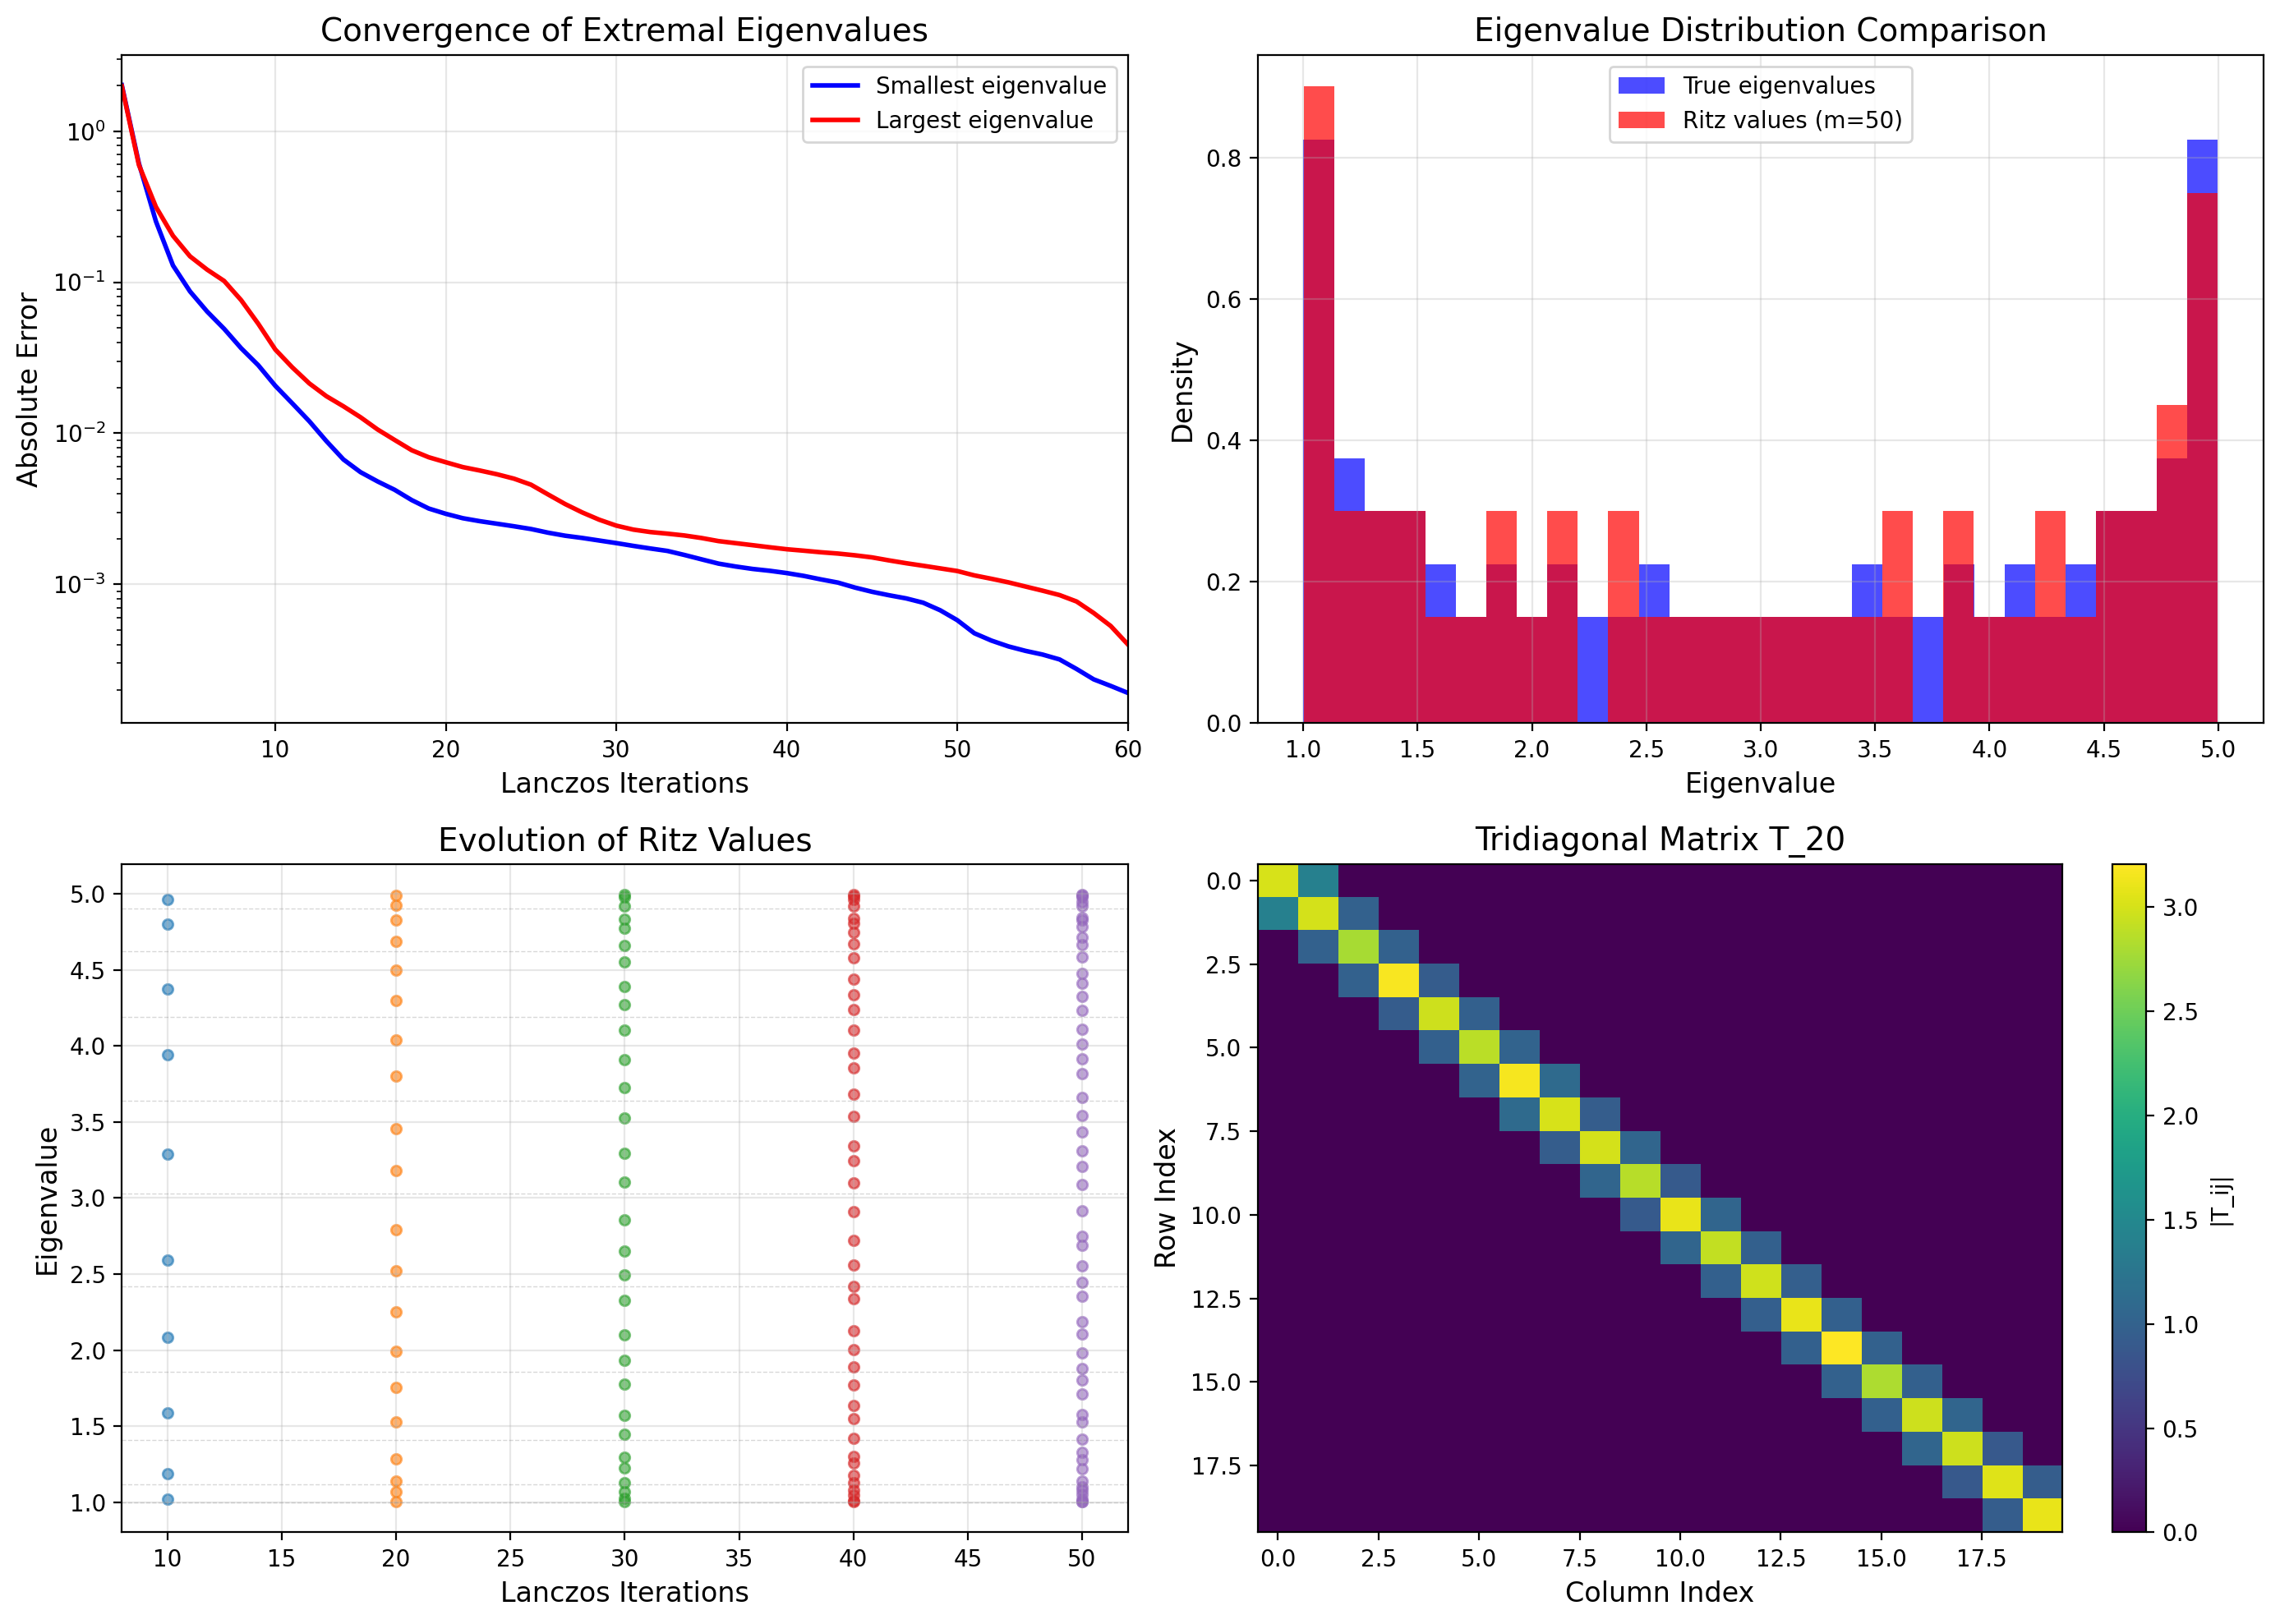


Plot saved to 'plot.png'


In [7]:
# Create figure with subplots
fig = plt.figure(figsize=(14, 10))

# Plot 1: Convergence of extremal eigenvalues
ax1 = fig.add_subplot(2, 2, 1)
iterations_plot = [d['iteration'] for d in convergence_data]
errors_min = [d['error_min'] for d in convergence_data]
errors_max = [d['error_max'] for d in convergence_data]

ax1.semilogy(iterations_plot, errors_min, 'b-', linewidth=2, label='Smallest eigenvalue')
ax1.semilogy(iterations_plot, errors_max, 'r-', linewidth=2, label='Largest eigenvalue')
ax1.set_xlabel('Lanczos Iterations', fontsize=12)
ax1.set_ylabel('Absolute Error', fontsize=12)
ax1.set_title('Convergence of Extremal Eigenvalues', fontsize=14)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_xlim([1, max_iter])

# Plot 2: Spectrum comparison
ax2 = fig.add_subplot(2, 2, 2)
m_final = 50
alpha_f, beta_f, V_f = lanczos_algorithm(A, v0, m_final)
ritz_final, _ = eigh_tridiagonal(alpha_f, beta_f[:-1] if len(beta_f) == len(alpha_f) else beta_f)

ax2.hist(true_eigenvalues, bins=30, alpha=0.7, label='True eigenvalues', color='blue', density=True)
ax2.hist(ritz_final, bins=30, alpha=0.7, label=f'Ritz values (m={m_final})', color='red', density=True)
ax2.set_xlabel('Eigenvalue', fontsize=12)
ax2.set_ylabel('Density', fontsize=12)
ax2.set_title('Eigenvalue Distribution Comparison', fontsize=14)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# Plot 3: Evolution of Ritz values
ax3 = fig.add_subplot(2, 2, 3)
for i, m in enumerate([10, 20, 30, 40, 50]):
    ritz_m = convergence_data[m-1]['ritz_values']
    ax3.scatter([m] * len(ritz_m), ritz_m, alpha=0.6, s=20, label=f'm={m}')

# Add true eigenvalues as horizontal lines for reference
for ev in true_eigenvalues[::10]:  # Every 10th eigenvalue
    ax3.axhline(y=ev, color='gray', linestyle='--', alpha=0.3, linewidth=0.5)

ax3.set_xlabel('Lanczos Iterations', fontsize=12)
ax3.set_ylabel('Eigenvalue', fontsize=12)
ax3.set_title('Evolution of Ritz Values', fontsize=14)
ax3.grid(True, alpha=0.3)

# Plot 4: Tridiagonal matrix structure
ax4 = fig.add_subplot(2, 2, 4)
m_show = 20
alpha_show, beta_show, _ = lanczos_algorithm(A, v0, m_show)

# Construct tridiagonal matrix for visualization
T = np.diag(alpha_show)
if len(beta_show) > 0:
    T += np.diag(beta_show[:-1] if len(beta_show) == len(alpha_show) else beta_show, k=1)
    T += np.diag(beta_show[:-1] if len(beta_show) == len(alpha_show) else beta_show, k=-1)

im = ax4.imshow(np.abs(T), cmap='viridis', aspect='auto')
plt.colorbar(im, ax=ax4, label='|T_ij|')
ax4.set_xlabel('Column Index', fontsize=12)
ax4.set_ylabel('Row Index', fontsize=12)
ax4.set_title(f'Tridiagonal Matrix T_{m_show}', fontsize=14)

plt.tight_layout()
plt.savefig('lanczos_algorithm_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved to 'plot.png'")

## Numerical Stability Considerations

The basic Lanczos algorithm suffers from loss of orthogonality due to finite precision arithmetic. Our implementation includes **full reorthogonalization** to maintain numerical stability. Other strategies include:

1. **Selective reorthogonalization**: Only reorthogonalize when needed
2. **Partial reorthogonalization**: Use bounds to decide when to reorthogonalize
3. **Implicit restart**: Restart with a refined starting vector

In [8]:
# Demonstrate orthogonality preservation
m_test = 50
alpha_t, beta_t, V_t = lanczos_algorithm(A, v0, m_test)

# Check orthogonality: V^T V should be identity
orthogonality_error = np.linalg.norm(V_t.T @ V_t - np.eye(m_test))
print(f"Orthogonality error (||V^T V - I||): {orthogonality_error:.2e}")

# Check that T = V^T A V
T_test = np.diag(alpha_t)
T_test += np.diag(beta_t[:-1], k=1)
T_test += np.diag(beta_t[:-1], k=-1)

projection_error = np.linalg.norm(V_t.T @ A @ V_t - T_test)
print(f"Projection error (||V^T A V - T||): {projection_error:.2e}")

Orthogonality error (||V^T V - I||): 2.43e-15
Projection error (||V^T A V - T||): 8.94e-15


## Application: Computing Specific Eigenvalues

The Lanczos algorithm is particularly useful when we only need a few extremal eigenvalues of a large matrix.

In [9]:
# Find the 5 smallest and 5 largest eigenvalues
m_compute = 40
alpha_c, beta_c, V_c = lanczos_algorithm(A, v0, m_compute)
ritz_c, ritz_vecs = eigh_tridiagonal(alpha_c, beta_c[:-1])

# Sort and compare
ritz_sorted = np.sort(ritz_c)
true_sorted = np.sort(true_eigenvalues)

print("Comparison of 5 smallest eigenvalues:")
print("-" * 45)
print(f"{'True':>12} {'Lanczos':>12} {'Error':>12}")
print("-" * 45)
for i in range(5):
    error = abs(true_sorted[i] - ritz_sorted[i])
    print(f"{true_sorted[i]:12.6f} {ritz_sorted[i]:12.6f} {error:12.2e}")

print("\nComparison of 5 largest eigenvalues:")
print("-" * 45)
print(f"{'True':>12} {'Lanczos':>12} {'Error':>12}")
print("-" * 45)
for i in range(5):
    idx = -(i + 1)
    error = abs(true_sorted[idx] - ritz_sorted[idx])
    print(f"{true_sorted[idx]:12.6f} {ritz_sorted[idx]:12.6f} {error:12.2e}")

Comparison of 5 smallest eigenvalues:
---------------------------------------------
        True      Lanczos        Error
---------------------------------------------
    1.000967     1.002154     1.19e-03
    1.003869     1.010431     6.56e-03
    1.008701     1.047460     3.88e-02
    1.015460     1.078702     6.32e-02
    1.024139     1.129378     1.05e-01

Comparison of 5 largest eigenvalues:
---------------------------------------------
        True      Lanczos        Error
---------------------------------------------
    4.999033     4.997326     1.71e-03
    4.996131     4.983729     1.24e-02
    4.991299     4.964021     2.73e-02
    4.984540     4.922267     6.23e-02
    4.975861     4.840104     1.36e-01


## Conclusion

The Lanczos algorithm provides an efficient method for computing eigenvalues of large symmetric matrices by:

1. **Reducing** the problem to a tridiagonal form through Krylov subspace projection
2. **Exploiting** the three-term recurrence for efficient computation
3. **Converging rapidly** for extremal eigenvalues

Key applications include:
- Quantum chemistry (electronic structure calculations)
- Structural mechanics (vibration analysis)
- Data science (principal component analysis, spectral clustering)
- Network analysis (graph Laplacian eigenvalues)

The algorithm's efficiency makes it indispensable for problems where full eigendecomposition is computationally infeasible.